In [ ]:
import numpy as np
import pandas as pd
import csv
from os import listdir
import re
from ipywidgets import interact, interact_manual
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words_sp = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extractor del Directorio Estadístico Nacional de Unidades Económicas (INEGI)

El objetivo es generar un programa, una base de datos o tabular, que le permita conocer a mayor detalle por que tipo de negocios se componen los distintos estados de la republica mexicana.

In [ ]:
#Correr esta celda si se quiere cagar archivos denue.csv's
def capital(texto):
  words=texto.split(sep=' ')
  texto_cap=[word.capitalize() for word in words]
  resultado= " ".join(texto_cap)
  return resultado


def acentos(texto=""):
  words=texto.split(sep=' ')
  words=[re.sub(r"á", "a", word) for word in words]
  words=[re.sub(r"é", "e", word) for word in words]
  words=[re.sub(r"í", "i", word) for word in words]
  words=[re.sub(r"ó", "o", word) for word in words]
  words=[re.sub(r"ú", "u", word) for word in words]
  
  resultado= " ".join(words)
  return resultado

## Extractor y limpieza


*  Archivo compendio_total_contactable.txt (con | de separador) (carpeta de lectura y escritura)

*  Mensaje con tamaño, nombre de columnas y columnas faltantes

*  Filtrar por telefono o correo, compendio_total_contactable.txt

*  Quitar acentos, multiespacios y usar Capital()

In [ ]:
@interact_manual
def compendio_total(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/', dir_out='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/'):
  global columnas_compendio
  
  csv_files=[file for file in listdir(dir_int) if file[-3:] == 'csv' and file[:5] == 'denue']
  #csv_files=["denue_inegi_16_.csv","denue_inegi_17_.csv","denue_inegi_13_.csv"]

  with open(dir_out+'compendio_total_contactable.txt', "w") as my_output_file: #Archivo txt
    columnas_compendio=[]

    for csv_file in csv_files: 
        print('Cargando archivo: '+csv_file)
        i=0 #Numero de filas (archivo inicial)
        j=0#Numero de filas (archivo limpio)

        with open(dir_int+csv_file, "r", encoding = "ISO-8859-1") as my_input_file: #Abre un archivo csv

            for row in csv.reader(my_input_file):

                if  i==0: #Encabezado
                   row.append('Ruta_Origen')
                   columnas=row
                   print('  Columnas: ', columnas)

                   if csv_files.index(csv_file) == 0: #Si es el primer archivo se agregan las columnas
                     columnas_compendio=columnas
                   else:
                     column_extra=list(set(columnas).difference(set(columnas_compendio)))
                     column_faltante=list(set(columnas_compendio).difference(set(columnas)))
                     #print('')
                     
                     print('Este archivo no contiene la(s) columna(s): ', column_extra)
                     print('Este archivo contiene ademas la(s) columna(s): ', column_faltante)
                     columnas_compendio+= column_extra

                   my_output_file.write("|".join(row)+'\n') #Separador y salto de linea

                else:
                   row.append(csv_file) #Ruta_Origen
                   
                   telefono= len( re.findall(r"\d{10}", row[columnas_compendio.index('telefono')]) ) != 0
                   correo= len( re.findall(r"@", row[columnas_compendio.index('correoelec')]) ) != 0

                   if i==1: print('  Primera Fila: ',row)

                   if telefono or correo:
                      row=[ capital(acentos( re.sub(r"\s+", " ",col ).lower() ) ) for col in row]
                      my_output_file.write("|".join(row)+'\n') #Separador y salto de linea

                      if j==1: print('  Primera Fila Limpia: ',row)
                      j+=1
                   
      
                i+=1  

        print('  Total de filas (archivo inicial): '+str(i)) 
        print('  Total de filas (archivo contactable): '+str(j)) 
        print('  Total de columnas: '+str(len(row)))  
        print('')
        print('')
    my_output_file.close()



  print('  Se ha creado el archivo compendio_total.txt exitosamente!')
  

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/', description='dir_i…

## Analisis de Negocio

### Word Clouds

El objetivo es hacer un análisis de la base de datos contactable, para enunciar al área de negocio los giros principales por entidad federativa entre otras caracteristicas de los negocios mas frecuentes.

*	Filtrado de todos los registros que contenga la palabra Banco o cualquier otra palabra clave para un negocio en  las columnas: ['nom_estab', 'nombre_act', 'raz_social', 'entidad','tipo_vial','tipo_asent', 'tipoCenCom','municipio','localidad']
 
* WordCloud de las palabras mas frecuentes en la columna deseada de los registros filtrados previamente.

In [ ]:
@interact_manual
def word_cloud_busqueda_palabra(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_contactable.txt', palabra='Banco', 
                            col_busqueda=['nom_estab', 'nombre_act', 'raz_social', 'entidad','tipo_vial','tipo_asent', 'tipoCenCom','municipio','localidad'], 
                            col_cloud=['nom_estab', 'nombre_act', 'raz_social', 'entidad','tipo_vial','tipo_asent', 'tipoCenCom','municipio','localidad']):
  
    global datos

    with open(dir_int, "r") as file_clean:
        lines= file_clean.readlines()
        
        col_cloud_list=[]
        columnas_compendio=[]
        rows=[]
        j=1

        for line in lines:  #Leemos las lineas del archivo compendio total
            row=line.split(sep="|")
            if row[0] == 'id': columnas_compendio=row
            coincidencia= len( re.findall(palabra, row[columnas_compendio.index(col_busqueda)]) ) != 0

            if coincidencia :
                rows.append(row)
                col_cloud_list.append(row[columnas_compendio.index(col_cloud)])

                #print(j)
                #print('Nombre:', row[columnas_compendio.index('nom_estab')])
                #print('Actividad: ', row[columnas_compendio.index('nombre_act')])
                #print('Ocupacion: ', row[columnas_compendio.index('per_ocu')])
                #print('')
                j+=1              

        print('Total de negocios: ', str(j-1))
        print('')
        datos=pd.DataFrame(rows,  columns=columnas_compendio)

        cloud=WordCloud(stopwords= stop_words_sp, max_font_size=40, random_state=2).generate(' '.join(col_cloud_list))

        fig=plt.figure(figsize=(20,10))
        plt.imshow(cloud)
        plt.axis('off')
        plt.show()

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_conta…

* Se selecciona una estado y se realiza un WordCloud de la columna seleccionada 

In [ ]:
estados=['Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche', 'Coahuila De Zaragoza', 'Colima', 'Ciudad De Mexico','Chiapas', 'Chihuahua', 'Durango', 
         'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'Mexico', 'Michoacan De Ocampo', 'Morelos', 'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla', 'Queretaro', 'Quintana Roo', 
         'San Luis Potosi', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz De Ignacio De La Llave', 'Yucatan' ,'Zacatecas']

@interact_manual
def word_cloud_estado(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_contactable.txt', 
                            estado= estados, 
                            col_cloud=['nom_estab', 'nombre_act', 'raz_social','tipo_vial','tipo_asent', 'tipoCenCom','municipio','localidad']):
    global datos

    with open(dir_int, "r") as file_clean:
        lines= file_clean.readlines()

        col_cloud_list=[]
        rows=[]

        columnas_compendio=[]
        j=1
        telefono_count=1
        mail_count=1

        for line in lines:  #Leemos las lineas del archivo compendio total
            row=line.split(sep="|")
            if row[0] == 'id': 
                columnas_compendio=row

            coincidencia= len( re.findall(estado, row[columnas_compendio.index('entidad')]) ) != 0

            if coincidencia :
                rows.append(row)
                col_cloud_list.append(row[columnas_compendio.index(col_cloud)])

                if row[columnas_compendio.index('telefono')] == '': telefono_count+=1
                if row[columnas_compendio.index('correoelec')] == '': mail_count+=1

                #print(j)
                #print('Nombre:', row[columnas_compendio.index('nom_estab')])
                #print('Actividad: ', row[columnas_compendio.index('nombre_act')])
                #print('Ocupacion: ', row[columnas_compendio.index('per_ocu')])
                #print('')
                
                
                j+=1              

        print('Total de negocios en el estado de '+estado+':' ,str(j-1))
        print('Total de negocios con correo: ' ,str(telefono_count-1))
        print('Total de negocios con telefono: ' ,str(mail_count-1))
        print('')
        datos=pd.DataFrame(rows,  columns=columnas_compendio)

        cloud=WordCloud(stopwords= stop_words_sp, max_font_size=40, random_state=2).generate(' '.join(col_cloud_list))

        fig=plt.figure(figsize=(20,10))
        plt.imshow(cloud)
        plt.axis('off')
        plt.show()

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_conta…

Si se utiliza la funcion word_cloud_estado para la CDMX, los datos de dicha entidad se guardaran en el dataframe datos. De igual manera con la funcion word_cloud_busqueda_palabra.

De aqui en adelante los siguientes graficos se realizaran sobre el datafram llamado datos.

In [ ]:
datos.head()

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,tipo_v_e_2,nom_v_e_2,tipo_v_e_3,nom_v_e_3,numero_ext,letra_ext,edificio,edificio_e,numero_int,letra_int,tipo_asent,nomb_asent,tipoCenCom,nom_CenCom,num_local,cod_postal,cve_ent,entidad,cve_mun,municipio,cve_loc,localidad,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,Ruta_Origen\n
0,8441800,Agro Desarrolladores Nutricionales Y Especiali...,Agro Desarrolladores Nutricionales Y Especiali...,115111,Servicios De Fumigacion Agricola,6 A 10 Personas,Avenida,Insurgentes Sur,Circuito,Interior (avenida Rio Mixcoac),Calle,Ceres,Calle,Minerva,1524,,Centro Y Plaza Comercial,Piso 7,,,Colonia,Credito Constructor,Centro Y Plaza Comercial,Punta Insurgentes,703,3940,9,Ciudad De Mexico,14,Benito Juarez,1,Benito Juarez,717,19,5578221074,Agro.desarrollos@gmail.com,,Fijo,19.36655606,-99.18113203,2019-11,Denue_inegi_09_.csv\n
1,7337437,Arcam,,115111,Servicios De Fumigacion Agricola,0 A 5 Personas,Calle,Playa Rosarito,Avenida,Santiago,Calle,Playa Mexiquillo,Calle,Playa Mexiquillo,32,,,,,,Barrio,Barrio Santiago,,,,8820,9,Ciudad De Mexico,6,Iztacalco,1,Iztacalco,768,5,5513843251,Arcamcontrol@hotmail.com,,Fijo,19.3900294,-99.12524072,2019-11,Denue_inegi_09_.csv\n
2,6314564,Cafetalera Tepuzapa,Cafetalera Tepuzapa Sa De Cv,115119,Otros Servicios Relacionados Con La Agricultura,6 A 10 Personas,Calle,Alborada,Calle,Oasis,Calle,Planicie,Calle,Alborada,105,,,,,,Colonia,Parques Del Pedregal,,,,14010,9,Ciudad De Mexico,12,Tlalpan,1,Tlalpan,74,14,,Tepuzapa@prodigy.net.mx,,Fijo,19.30170108,-99.18765211,2010-07,Denue_inegi_09_.csv\n
3,696550,Comercializadora Y Distribuidora De Viveres Sa...,"Comercializadora De Viveres, Sa De Cv",115113,Beneficio De Productos Agricolas,6 A 10 Personas,Calle,1,Calle,Estroncio,Avenida,Prolongacion Rio Churubusco,Calle,2,377,,,,,,Colonia,Cuchilla Pantitlan,,,,15610,9,Ciudad De Mexico,17,Venustiano Carranza,1,Venustiano Carranza,884,18,5557013291,,,Fijo,19.42209471,-99.06767786,2014-12,Denue_inegi_09_.csv\n
4,708802,Empacadora Teotihuacan,Empacadora Teotihuacan Sa De Cv,115113,Beneficio De Productos Agricolas,0 A 5 Personas,Calle,Oriente 237-c,Calle,Sur 8,Calle,Sur 4-d,Eje Vial,5 Oriente (javier Rojo Gomez),31,,,,,,Colonia,Agricola Oriental,,,,8500,9,Ciudad De Mexico,6,Iztacalco,1,Iztacalco,325,20,,Empacadorateo@gmail.com,,Fijo,19.40144384,-99.07237847,2014-12,Denue_inegi_09_.csv\n


In [ ]:
datos.shape

(177036, 42)

### Actividades mas Frecuentes

Numero de Actividades unicas:  907


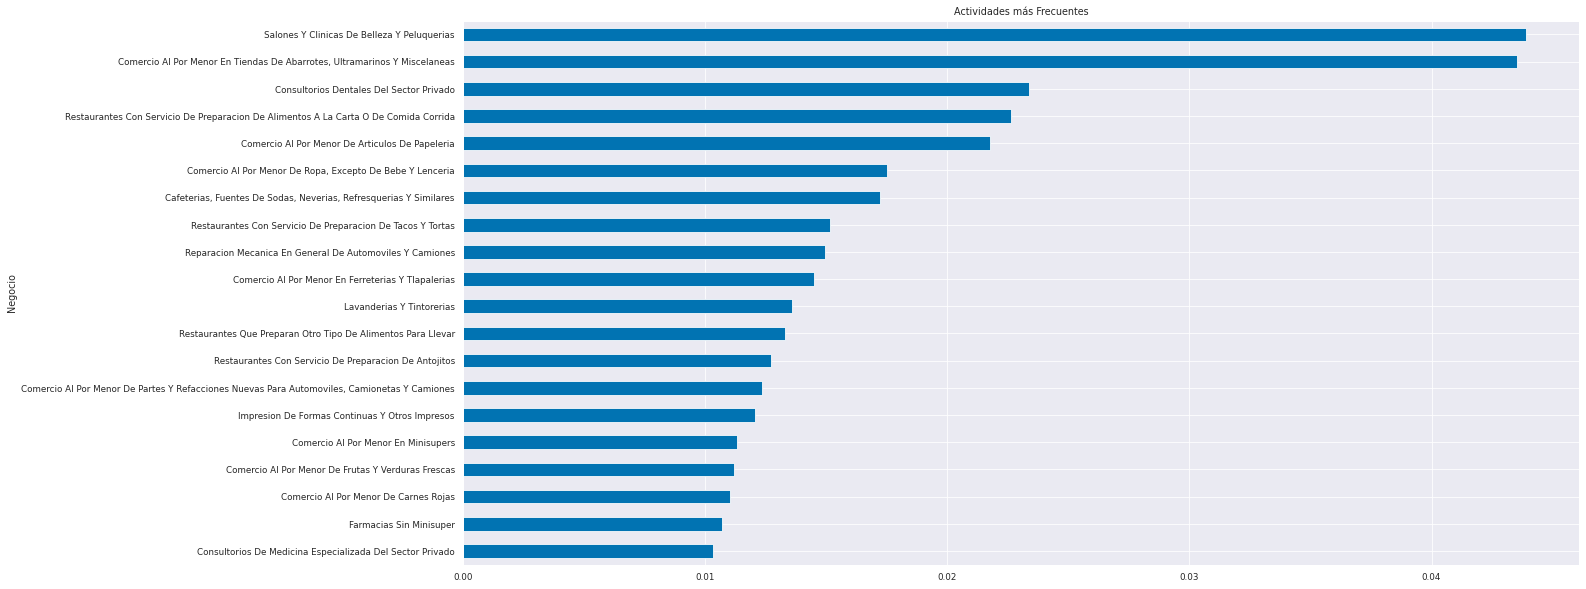

In [ ]:
actividades_unicas= datos.nombre_act.value_counts(normalize=True).sort_values(ascending=True)
print('Numero de Actividades unicas: ', len(actividades_unicas))

sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("colorblind")

plt.figure(figsize=(20,10))
actividades_unicas[-20:].plot(kind='barh', title='Actividades más Frecuentes', xlabel='Negocio', ylabel='%')
plt.show()


Numero de Actividades unicas:  907


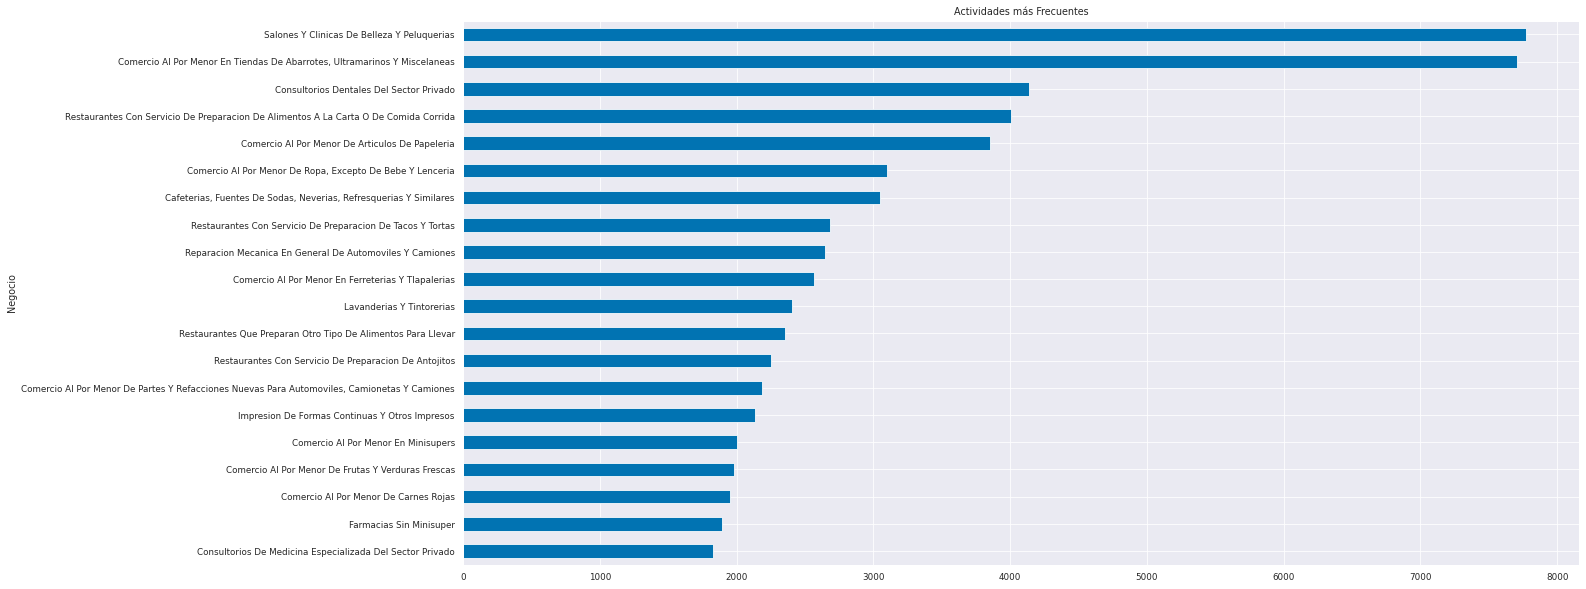

In [ ]:
actividades_unicas= datos.nombre_act.value_counts().sort_values(ascending=True)
print('Numero de Actividades unicas: ', len(actividades_unicas))

sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("colorblind")

plt.figure(figsize=(20,10))
actividades_unicas[-20:].plot(kind='barh', title='Actividades más Frecuentes', xlabel='Negocio', ylabel='Total de Negocios')
plt.show()

In [ ]:
datos.columns

Index(['id', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act', 'per_ocu',
       'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1', 'tipo_v_e_2',
       'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext', 'letra_ext',
       'edificio', 'edificio_e', 'numero_int', 'letra_int', 'tipo_asent',
       'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local', 'cod_postal',
       'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc', 'localidad',
       'ageb', 'manzana', 'telefono', 'correoelec', 'www', 'tipoUniEco',
       'latitud', 'longitud', 'fecha_alta', 'Ruta_Origen\n'],
      dtype='object')

### Grafico de barras de Numero de Trabajadores

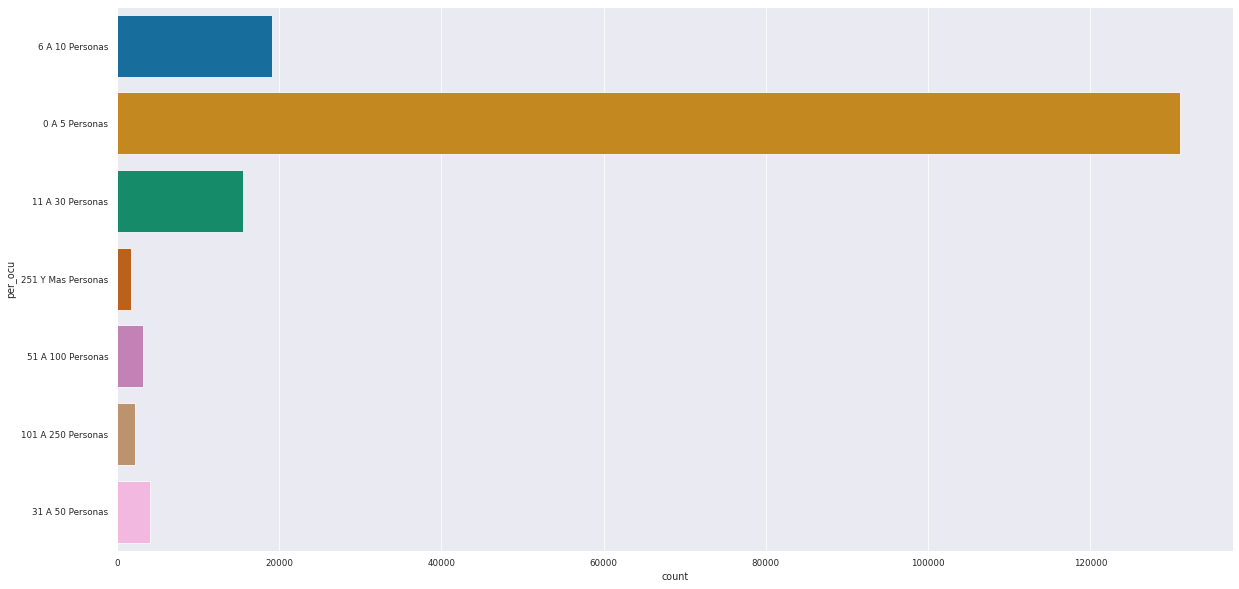

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(data=datos, y='per_ocu')
plt.show()

In [ ]:
print(datos[['per_ocu']].value_counts(ascending=False, normalize=True))

per_ocu           
0 A 5 Personas        0.739946
6 A 10 Personas       0.108074
11 A 30 Personas      0.087937
31 A 50 Personas      0.023148
51 A 100 Personas     0.018318
101 A 250 Personas    0.012992
251 Y Mas Personas    0.009586
dtype: float64


### Mapas de calor por categorias

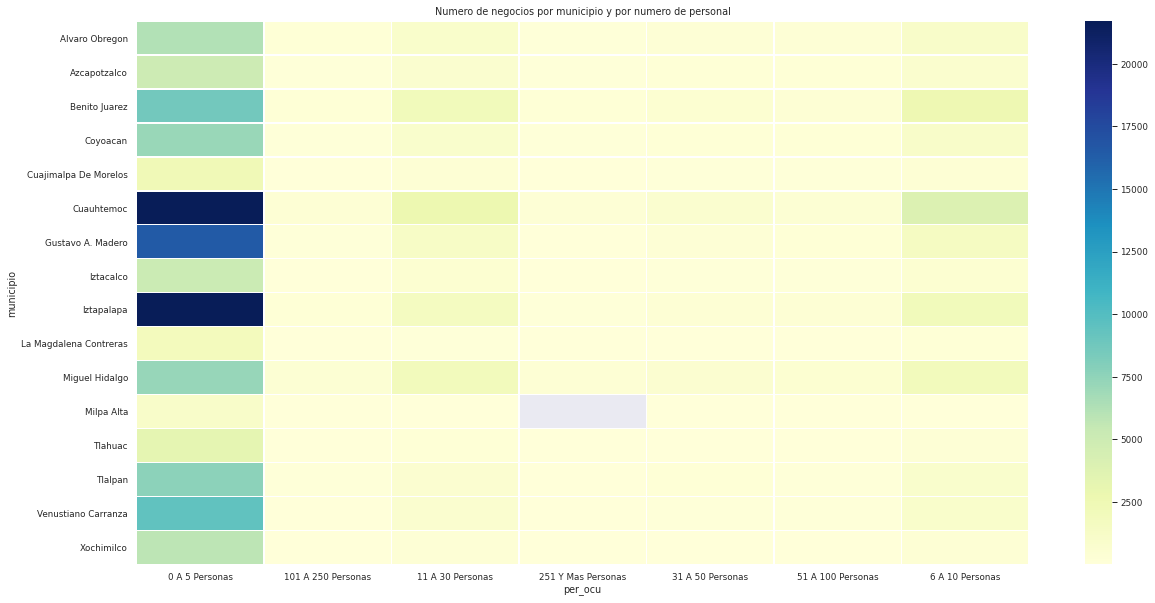

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(datos.municipio, datos.per_ocu, values=datos.id, aggfunc='count') ,cmap='YlGnBu', linewidths=.5)
plt.title('Numero de negocios por municipio y por numero de personal')
plt.show()

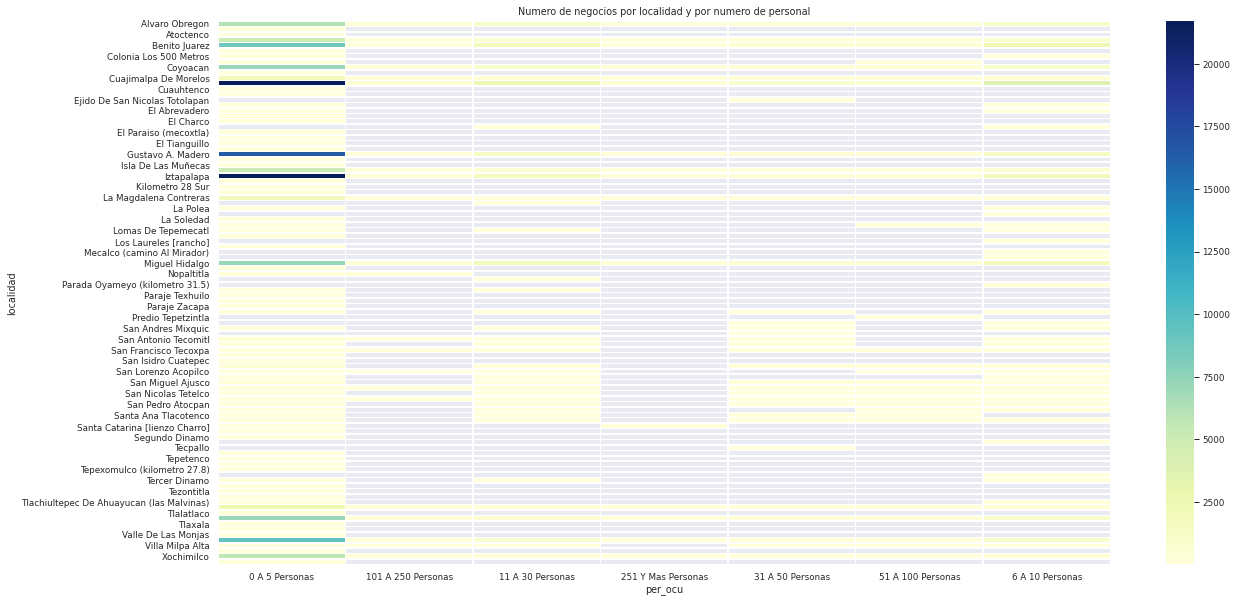

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(datos.localidad, datos.per_ocu, values=datos.id, aggfunc='count') ,cmap='YlGnBu', linewidths=.5)
plt.title('Numero de negocios por localidad y por numero de personal')
plt.show()

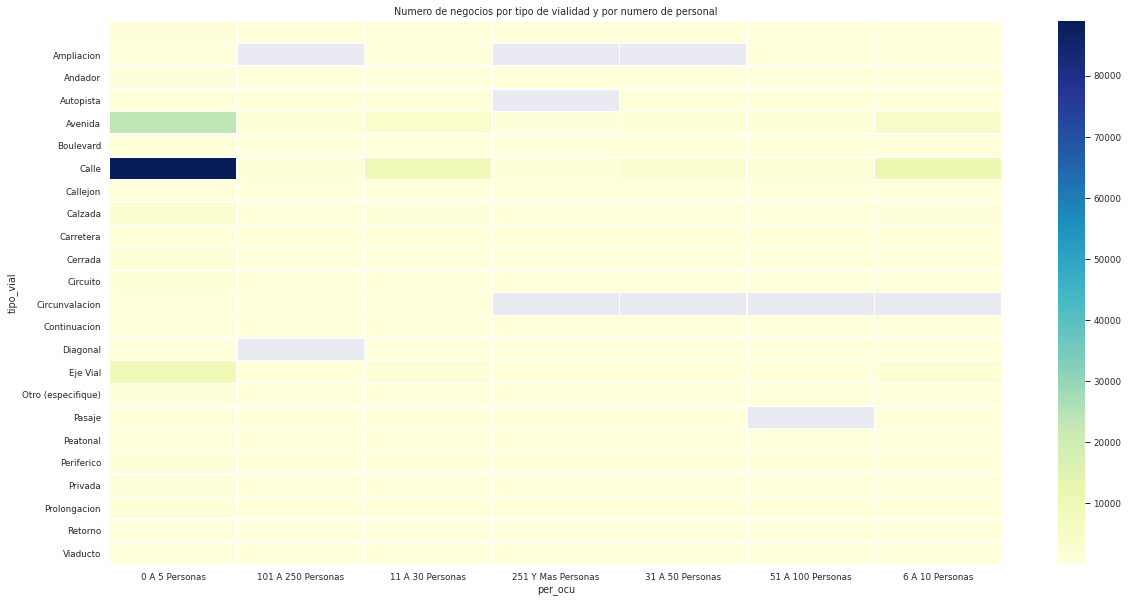

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(datos.tipo_vial, datos.per_ocu, values=datos.id, aggfunc='count') ,cmap='YlGnBu', linewidths=.5)
plt.title('Numero de negocios por tipo de vialidad y por numero de personal')
plt.show()

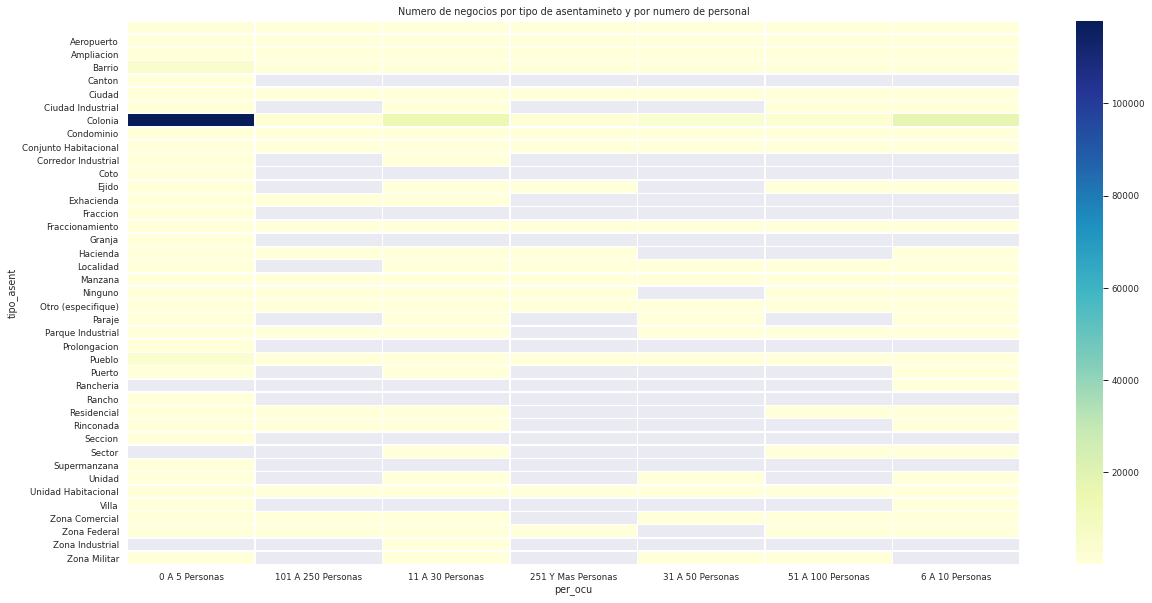

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(datos.tipo_asent, datos.per_ocu, values=datos.id, aggfunc='count') ,cmap='YlGnBu', linewidths=.5)
plt.title('Numero de negocios por tipo de asentamineto y por numero de personal')
plt.show()

### Mapa de negocios filtrados

Ahora filtraremos primero por columna y luego por una categoria en dicha columna

In [ ]:
@interact_manual
def filtro_columna(columna=['localidad','tipo_vial','tipo_asent', 'tipoCenCom','municipio','estado', 'per_ocu']):
  global columna_sel
  global values_col
  columna_sel=columna
  values_col=datos[columna_sel].sort_values(ascending=True).unique()
  print('Listo!', columna_sel)

interactive(children=(Dropdown(description='columna', options=('localidad', 'tipo_vial', 'tipo_asent', 'tipoCe…

In [ ]:
@interact_manual
def filtro_cattegori_columna(filtro=values_col):
  global datos_filtrados
  datos_filtrados=datos[datos[columna_sel] == filtro]
  datos_filtrados[['latitud','longitud']]=datos_filtrados[['latitud','longitud']].apply(lambda x: x.astype('float'))
  print('Listo!', filtro)


interactive(children=(Dropdown(description='filtro', options=('', 'Ampliacion', 'Andador', 'Autopista', 'Aveni…

In [ ]:
locat=[datos_filtrados['latitud'].iloc[0], datos_filtrados['longitud'].iloc[0]]
map=folium.Map(location=locat)
for row in datos_filtrados.iterrows():
  row_values=row[1]
  location=[row_values['latitud'], row_values['longitud']]
  marker=folium.Marker(location=location).add_to(map)

In [ ]:
display(map)

### N-grams

Suponiendo que no tuvieramos el apoyo del campo de nombre de actividad, sería importante observar que sí sabemos de nuestros datos, por su contenido:

*  Hacer una diagrama de bi-palabras y un Ngram (2 o 3) para entender que tipo de servicios se van a promover por estado (todos) usando solo el nombre del establecimiento

* En el ejemplo no se ha hecho limpieza ¿Qué tipo de limpiezas se pueden hacer?  (ngram, count)

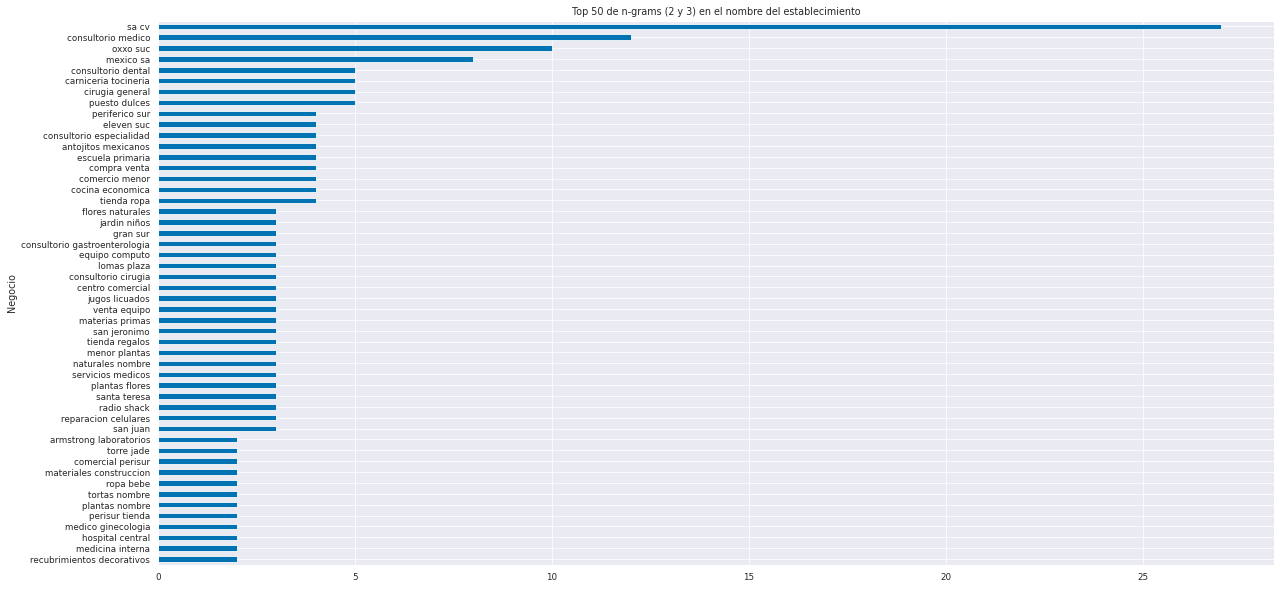

In [ ]:
vect= CountVectorizer(max_features=50, 
                      stop_words=stop_words_sp, 
                      ngram_range=(2,2))

X=vect.fit_transform(datos_filtrados.nom_estab) 

plt.figure(figsize=(20,10))
top_50_bi_tri_grams=pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
top_50_bi_tri_grams.sum().sort_values(ascending=True).plot(kind='barh', title='Top 50 de n-grams (2 y 3) en el nombre del establecimiento', 
                                                           xlabel='Negocio', ylabel='Total de Negocios')
plt.show()

In [ ]:
top_50_bi_tri_grams.head()

,antojitos mexicanos,armstrong laboratorios,carniceria tocineria,centro comercial,cirugia general,cocina economica,comercial perisur,comercio menor,compra venta,consultorio cirugia,consultorio dental,consultorio especialidad,consultorio gastroenterologia,consultorio medico,eleven suc,equipo computo,escuela primaria,flores naturales,gran sur,hospital central,jardin niños,jugos licuados,lomas plaza,materiales construccion,materias primas,medicina interna,medico ginecologia,menor plantas,mexico sa,naturales nombre,oxxo suc,periferico sur,perisur tienda,plantas flores,plantas nombre,puesto dulces,radio shack,recubrimientos decorativos,reparacion celulares,ropa bebe,sa cv,san jeronimo,san juan,santa teresa,servicios medicos,tienda regalos,tienda ropa,torre jade,tortas nombre,venta equipo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
